In [311]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential

In [313]:
df=pd.read_csv('monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [314]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


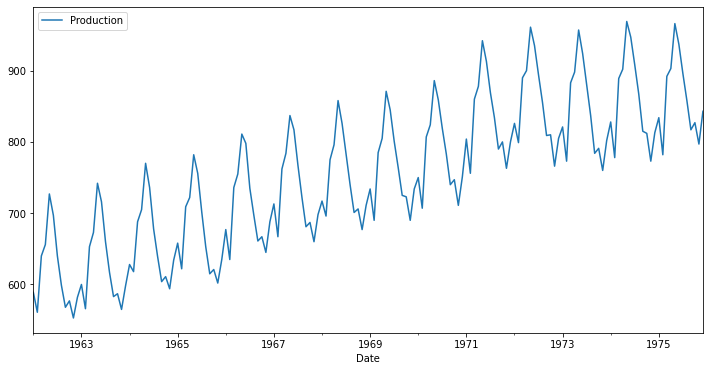

In [315]:

df.plot(figsize=(12,6))

In [316]:
from statsmodels.tsa.seasonal import seasonal_decompose


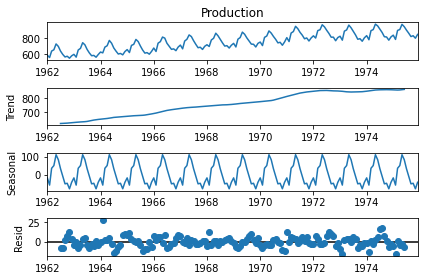

In [317]:
results = seasonal_decompose(df['Production'])
results.plot();

In [318]:
len(df)

168

In [319]:

train = df.iloc[:156]
test = df.iloc[156:]

In [320]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [321]:

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [322]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

# formatting the data

In [323]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [324]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [325]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [326]:
X.shape

(1, 3, 1)

In [327]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [328]:
#doing same things for 12 months
n_input=12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
#defining model
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_feature)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [329]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fitting the model
model.fit(generator,epochs=500)

Epoch 1/500
144/144 [==============================] - 1s 5ms/step - loss: 0.0086
Epoch 2/500
144/144 [==============================] - 1s 5ms/step - loss: 0.0150TA: 0s - los
Epoch 3/500
144/144 [==============================] - 1s 5ms/step - loss: 0.0064
Epoch 4/500
144/144 [==============================] - 1s 5ms/step - loss: 0.0049
Epoch 5/500
144/144 [==============================] - 1s 5ms/step - loss: 0.0049
Epoch 6/500
144/144 [==============================] - 1s 5ms/step - loss: 0.0039
Epoch 7/500
144/144 [==============================] - 1s 5ms/step - loss: 0.0047
Epoch 8/500
144/144 [==============================] - 1s 5ms/step - loss: 0.0042
Epoch 9/500
144/144 [==============================] - 1s 5ms/step - loss: 0.0036
Epoch 10/500
144/144 [==============================] - 1s 5ms/step - loss: 0.0055
Epoch 11/500
144/144 [==============================] - 1s 5ms/step - loss: 0.0039
Epoch 12/500
144/144 [==============================] - 1s 5ms/step - loss: 0.0033
E

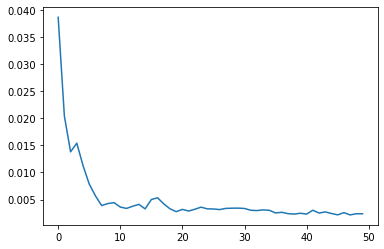

In [290]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [291]:
#how to make prediction
last_train_batch=scaled_train[-12:]

In [292]:
last_train_batch=last_train_batch.reshape((1,n_input,n_feature))

In [293]:
model.predict(last_train_batch)

array([[0.64783794]], dtype=float32)

In [294]:
scaled_test[0]

array([0.67548077])

In [295]:
#making prediction on test data

In [296]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [297]:
test_predictions

[array([0.64783794], dtype=float32),
 array([0.62135524], dtype=float32),
 array([0.8026704], dtype=float32),
 array([0.870217], dtype=float32),
 array([0.9747544], dtype=float32),
 array([0.95919704], dtype=float32),
 array([0.8855319], dtype=float32),
 array([0.7858371], dtype=float32),
 array([0.675903], dtype=float32),
 array([0.63431376], dtype=float32),
 array([0.5812838], dtype=float32),
 array([0.61582667], dtype=float32)]

In [298]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [299]:
true_predictions=scaler.inverse_transform(test_predictions)

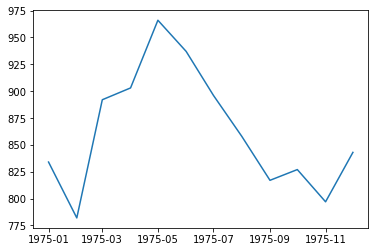

In [307]:
plt.plot(test)

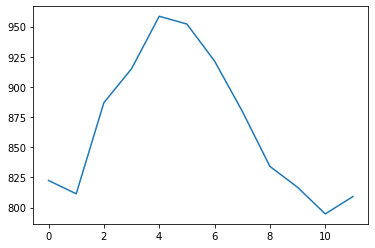

In [301]:
plt.plot(true_predictions)

In [256]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],true_predictions))
print(rmse)

26.692705547604646
